# Práctica sobre redes bayesianas

Disponemos de un [*dataset*](https://github.com/cayetanoguerra/cayetanoguerra.github.io/blob/master/ia/nbpy/data/exoplanets.xls) de [exoplanetas](https://es.wikipedia.org/wiki/Planeta_extrasolar#:~:text=Un%20planeta%20extrasolar%20o%20exoplaneta,cient%C3%ADfica%20en%20el%20siglo%20XX.) que cuenta con los siguientes datos:

- **Radio:** (metros) - variable real
- **Masa:** (kilogramos) - variable real
- **Gravedad:** (relativa respecto a la terrestre) - variable real
- **Atmósfera:** variable binaria
- **Oxígeno:** variable binaria
- **Temperatura promedio:** (grados centígrados) - variable real
- **Existencia de agua:** variables binaria
- **Periodo de rotación:** (horas) - variable real
- **Vida:** variable binaria

<img src="imgs/exoplanetas.jpg">

Deberás desarrollar una red bayesiana que retorne la probabilidad de que haya vida en un determinado planeta en función de sus propiedades.

Observa que no todos los datos son categóricos, así que deberás categorizarlos antes. Para ello, puedes definir rangos en los datos reales para obtener categorías. Por ejemplo, la propiedad **radio** puedes categorizarla como **pequeño**, **medio** y **grande**.

### Tareas

1) Categoriza las variables reales como consideres.

2) Mediante la librería **bnlearn** obtén el grafo de manera automática de la red bayesiana y reflexiona sobre su verosimilitud. Cámbialo manualmente si lo crees conveniente.

3) Busca de manera automática las tablas de probabilidad condicionada de la red.

4) Escoge algunas propiedades de los planetas y realiza la inferencia sobre ellos.

La práctica debe ser realizada mediante un notebook de Jupyter. Describe apropiadamente el código y su función.
 

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bnlearn as bn

In [66]:
data = pd.read_excel("exoplanets.xls")
data.head()

,radius (m),mass (kg),gravity,atmosphere,oxygene,avg_temp (C),water,rotational_period (h),life
0,11473000.0,3.478097e+25,1.80,YES,YES,35.8,YES,50.5,NO
1,10440000.0,2.620465e+25,1.64,NO,NO,34.5,NO,30.5,NO
2,12520000.0,4.518792e+25,1.96,YES,YES,42.1,YES,12.3,YES
3,11727000.0,3.714528e+25,1.84,YES,YES,39.0,NO,24.5,NO
4,7285000.0,8.903243e+24,1.14,NO,NO,9.3,NO,32.7,NO


## Creamos tabla nueva

In [67]:
df = pd.DataFrame()

## Masa

In [68]:
bins = 3
group_names = ["PEQUEÑO","MEDIANO","GRANDE"]
df["mass"] = pd.qcut(data[list(data)[1]], q = bins, labels=group_names)
df.head()
        

,mass
0,GRANDE
1,GRANDE
2,GRANDE
3,GRANDE
4,PEQUEÑO


# Temperatura
Para categorizar la temperatura, hemos investigado que la vida tiende a oscilar entre -18ºC y 50ºC. La temperatura media resultante sería de 16ºC. Por lo tanto, dado que el objetivo es determinar qué planetas tienen más probabilidades de tener vida, hemos decidido categorizar la temperatura en tres rangos: frío, ideal y cálido. En donde la categoría ideal sería la temperatura media de 16ºC con un offset de 5 ºC hacia arriba y hacia abajo. Los rangos frío y cálido serían los que estén por debajo y por encima de la temperatura ideal, respectivamente.

In [69]:
bins = [data[list(data)[5]].values.min(), 11, 21, data[list(data)[5]].values.max()]
group_names = ["FRÍO","IDEAL","CALIENTE"]
df["temp"] = pd.cut(data[list(data)[5]], bins, labels=group_names)
df.head()

,mass,temp
0,GRANDE,CALIENTE
1,GRANDE,CALIENTE
2,GRANDE,CALIENTE
3,GRANDE,CALIENTE
4,PEQUEÑO,FRÍO


In [70]:
df["temp"].value_counts()

CALIENTE    8433
FRÍO         882
IDEAL        684
Name: temp, dtype: int64

## Radio
Para categorizar el radio hemos decidido tomar como referencia a La Tierra y Marte, siendo estos planetas los que conformarán el apartado de "Mediano".

In [71]:
bins = [data[list(data)[0]].values.min(), 3389500, 6371000, data[list(data)[0]].values.max()]
group_names = ["PEQUEÑO","MEDIANO","GRANDE"]
df["radius"] = pd.cut(data[list(data)[0]], bins, labels=group_names)
df.head()

,mass,temp,radius
0,GRANDE,CALIENTE,GRANDE
1,GRANDE,CALIENTE,GRANDE
2,GRANDE,CALIENTE,GRANDE
3,GRANDE,CALIENTE,GRANDE
4,PEQUEÑO,FRÍO,GRANDE


In [72]:
df["radius"].value_counts()

GRANDE     8069
MEDIANO    1610
PEQUEÑO     320
Name: radius, dtype: int64

## Gravedad

Hay algunas evidencias que sugieren que una gravedad entre el 0,5 y el 2 veces la gravedad de la Tierra, por lo tanto, seguiremos dicho criterio

In [73]:
bins = [data[list(data)[2]].values.min(), 0.5, 2, data[list(data)[2]].values.max()]
group_names = ["POCA","IDEAL","MUCHA"]
df["gravity"] = pd.cut(data[list(data)[2]], bins, labels=group_names)
df.head()

,mass,temp,radius,gravity
0,GRANDE,CALIENTE,GRANDE,IDEAL
1,GRANDE,CALIENTE,GRANDE,IDEAL
2,GRANDE,CALIENTE,GRANDE,IDEAL
3,GRANDE,CALIENTE,GRANDE,IDEAL
4,PEQUEÑO,FRÍO,GRANDE,IDEAL


## Periodo de rotación

El periodo de rotación lo situaremos como ideal 4 horas por arriba y por debajo de La Tierra

In [74]:
bins = [data[list(data)[7]].values.min(), 20, 28, data[list(data)[7]].values.max()]
group_names = ["RÁPIDO","IDEAL","LENTO"]
df["rotation_duration"] = pd.cut(data[list(data)[7]], bins, labels=group_names)
df.head()


,mass,temp,radius,gravity,rotation_duration
0,GRANDE,CALIENTE,GRANDE,IDEAL,LENTO
1,GRANDE,CALIENTE,GRANDE,IDEAL,LENTO
2,GRANDE,CALIENTE,GRANDE,IDEAL,RÁPIDO
3,GRANDE,CALIENTE,GRANDE,IDEAL,IDEAL
4,PEQUEÑO,FRÍO,GRANDE,IDEAL,LENTO


In [75]:
df["atmosphere"] = data[list(data)[3]]
df["oxygene"] = data[list(data)[4]]
df["water"] = data[list(data)[6]]
df["life"] = data[list(data)[8]]
df.head()

,mass,temp,radius,gravity,rotation_duration,atmosphere,oxygene,water,life
0,GRANDE,CALIENTE,GRANDE,IDEAL,LENTO,YES,YES,YES,NO
1,GRANDE,CALIENTE,GRANDE,IDEAL,LENTO,NO,NO,NO,NO
2,GRANDE,CALIENTE,GRANDE,IDEAL,RÁPIDO,YES,YES,YES,YES
3,GRANDE,CALIENTE,GRANDE,IDEAL,IDEAL,YES,YES,NO,NO
4,PEQUEÑO,FRÍO,GRANDE,IDEAL,LENTO,NO,NO,NO,NO


In [76]:
DAG = bn.structure_learning.fit(df)


[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Compute structure scores ['k2', 'bds', 'bic', 'bdeu'] for model comparison (higher is better).


[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


{'ax': <Figure size 1500x1000 with 1 Axes>,
 'pos': {'mass': array([-0.3490586 , -0.22631898]),
  'temp': array([0.68166082, 0.46856788]),
  'radius': array([-0.3520968 , -0.54409876]),
  'gravity': array([-0.52990949, -0.86448562]),
  'rotation_duration': array([ 1.       , -0.2086874]),
  'atmosphere': array([-0.155979  ,  0.41512854]),
  'oxygene': array([-0.02014238,  0.59111343]),
  'water': array([-0.19198058,  0.07219638]),
  'life': array([-0.08249397,  0.29658453])},
 'G': <networkx.classes.digraph.DiGraph at 0x2609bc7fac0>,
 'node_properties': {'mass': {'node_color': '#1f456e', 'node_size': 800},
  'temp': {'node_color': '#1f456e', 'node_size': 800},
  'radius': {'node_color': '#1f456e', 'node_size': 800},
  'gravity': {'node_color': '#1f456e', 'node_size': 800},
  'rotation_duration': {'node_color': '#1f456e', 'node_size': 800},
  'atmosphere': {'node_color': '#1f456e', 'node_size': 800},
  'oxygene': {'node_color': '#1f456e', 'node_size': 800},
  'water': {'node_color': '#1

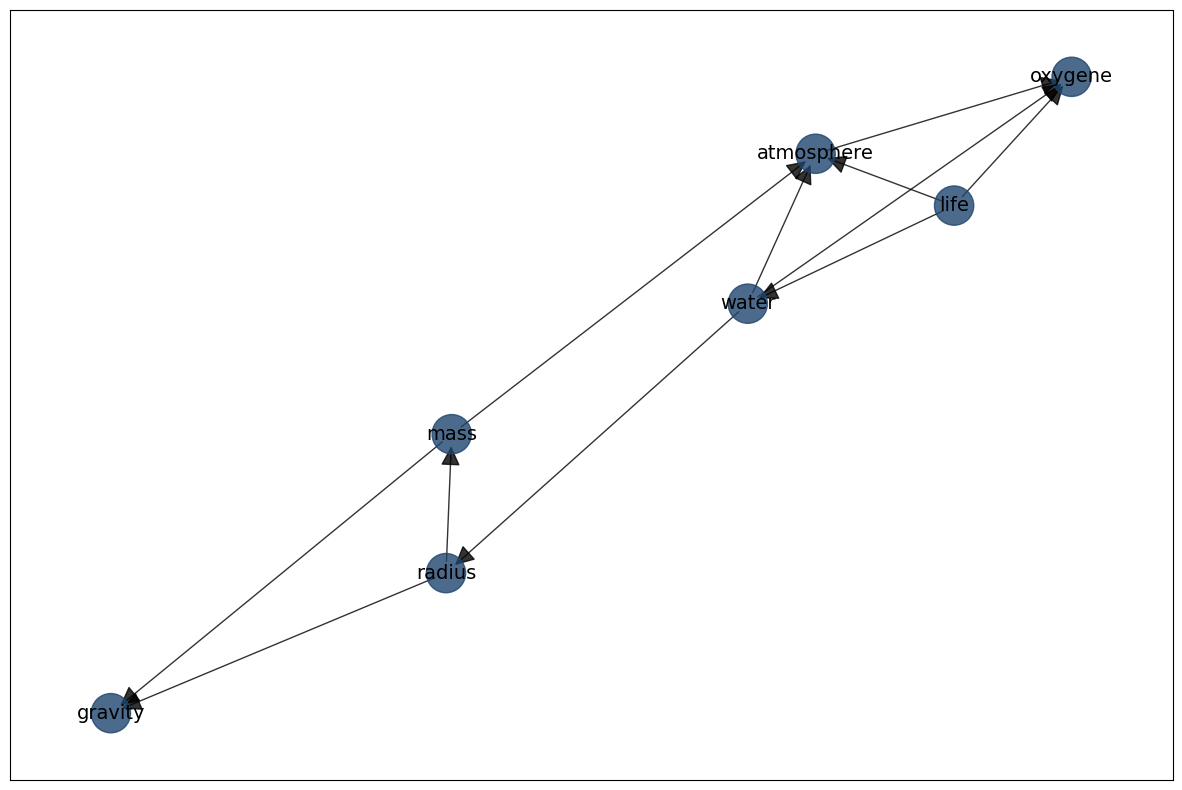

In [77]:
bn.plot(DAG, interactive=False)#poner interactive en true para que se pueda mover el grafo

In [78]:
df.head()

,mass,temp,radius,gravity,rotation_duration,atmosphere,oxygene,water,life
0,GRANDE,CALIENTE,GRANDE,IDEAL,LENTO,YES,YES,YES,NO
1,GRANDE,CALIENTE,GRANDE,IDEAL,LENTO,NO,NO,NO,NO
2,GRANDE,CALIENTE,GRANDE,IDEAL,RÁPIDO,YES,YES,YES,YES
3,GRANDE,CALIENTE,GRANDE,IDEAL,IDEAL,YES,YES,NO,NO
4,PEQUEÑO,FRÍO,GRANDE,IDEAL,LENTO,NO,NO,NO,NO


In [79]:
edges = [('mass', 'gravity'),
         ('radius', 'gravity'),
         ('temp', 'atmosphere'),
         ('gravity', 'atmosphere'), 
         ('atmosphere', 'water'),
         ('atmosphere', 'oxygene'),
         ('mass', 'rotation_duration'),
         ('oxygene', 'water'),
         ('water', 'life'),
         ('atmosphere', 'life'),
         ('oxygene', 'life'),
         ('rotation_duration', 'temp'),
         ('temp', 'life'), 
         ('gravity', 'life')
         ]

DAG_handmade = bn.make_DAG(edges)

[bnlearn] >bayes DAG created.


[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


{'ax': <Figure size 1500x1000 with 1 Axes>,
 'pos': {'mass': array([-0.39248797,  0.07876999]),
  'gravity': array([0.6289408 , 0.06794018]),
  'radius': array([0.32234342, 0.95872596]),
  'temp': array([ 0.04105784, -0.56996449]),
  'atmosphere': array([ 0.19888638, -0.00738437]),
  'water': array([-0.1396595 ,  0.38857127]),
  'oxygene': array([-0.17510986, -0.13235235]),
  'rotation_duration': array([-1.        , -0.23250952]),
  'life': array([ 0.5160289 , -0.55179666])},
 'G': <networkx.classes.digraph.DiGraph at 0x2609bd02a90>,
 'node_properties': {'mass': {'node_color': '#1f456e', 'node_size': 800},
  'gravity': {'node_color': '#1f456e', 'node_size': 800},
  'radius': {'node_color': '#1f456e', 'node_size': 800},
  'temp': {'node_color': '#1f456e', 'node_size': 800},
  'atmosphere': {'node_color': '#1f456e', 'node_size': 800},
  'water': {'node_color': '#1f456e', 'node_size': 800},
  'oxygene': {'node_color': '#1f456e', 'node_size': 800},
  'rotation_duration': {'node_color': '#1

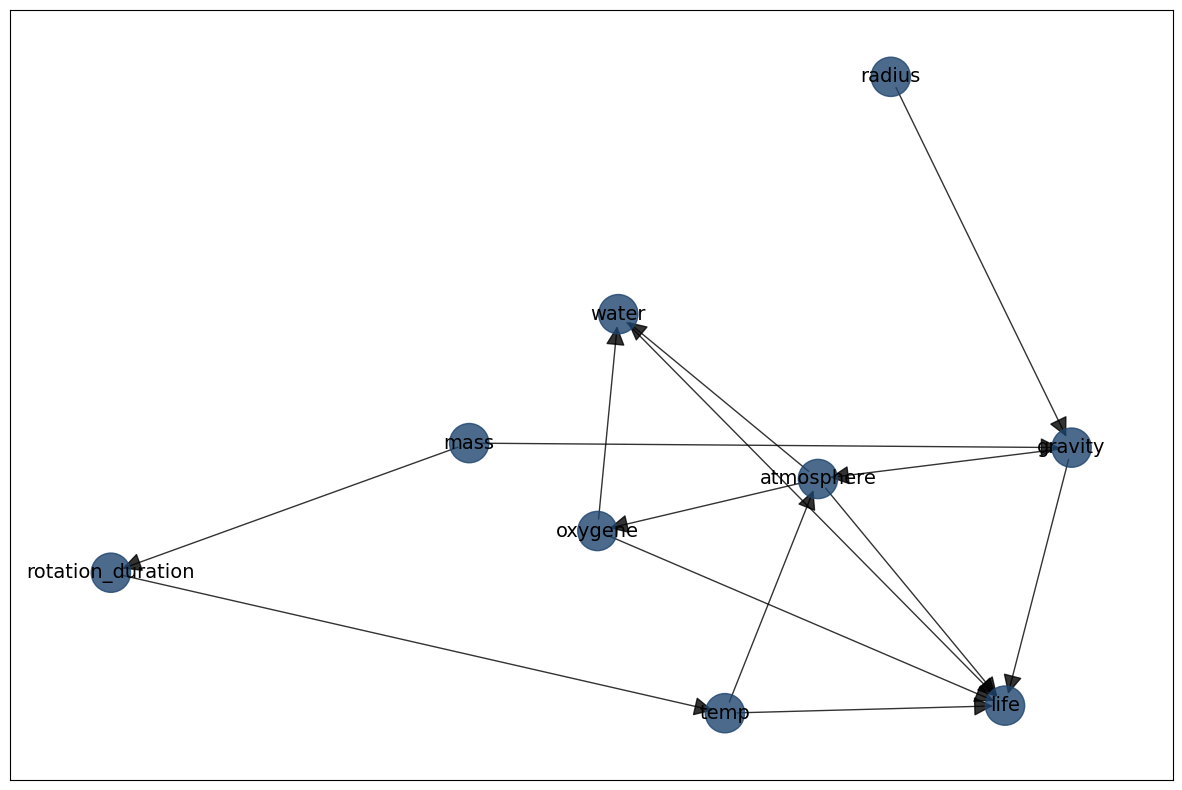

In [80]:
bn.plot(DAG_handmade, interactive=False) #poner interactive en true para que se pueda ver el grafo

In [81]:
model = bn.parameter_learning.fit(DAG_handmade, df)

[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >CPD of mass:
+---------------+----------+
| mass(GRANDE)  | 0.333303 |
+---------------+----------+
| mass(MEDIANO) | 0.333394 |
+---------------+----------+
| mass(PEQUEÑO) | 0.333303 |
+---------------+----------+
[bnlearn] >CPD of gravity:
+----------------+-----+--------------------+
| mass           | ... | mass(PEQUEÑO)      |
+----------------+-----+--------------------+
| radius         | ... | radius(PEQUEÑO)    |
+----------------+-----+--------------------+
| gravity(IDEAL) | ... | 0.1647766323024055 |
+----------------+-----+--------------------+
| gravity(MUCHA) | ... | 0.0859106529209622 |
+----------------+-----+--------------------+
| gravity(POCA)  | ... | 0.7493127147766323 |
+----------------+-----+--------------------+
[bnlearn] >CPD of radius:
+-----------------+-----------+
| radius(GRANDE)  | 0.763875  |
+-----------------+-----------+
| radius(MEDIANO) | 0.176715  |
+-----------------+-

In [87]:
q3 = bn.inference.fit(model, variables=['gravity'], evidence={'mass':'GRANDE', 'radius':'GRANDE'})

[bnlearn] >Variable Elimination..
[bnlearn] >Data is stored in [query.df]
+----+-----------+-----------+
|    |   gravity |         p |
+====+===========+===========+
|  0 |         0 | 0.689794  |
+----+-----------+-----------+
|  1 |         1 | 0.299449  |
+----+-----------+-----------+
|  2 |         2 | 0.0107569 |
+----+-----------+-----------+


In [83]:
q4 = bn.inference.fit(model, variables = ['atmosphere'], evidence = {'temp':'IDEAL', 'gravity':'IDEAL'})

[bnlearn] >Variable Elimination..
[bnlearn] >Data is stored in [query.df]
+----+--------------+----------+
|    |   atmosphere |        p |
+====+==============+==========+
|  0 |            0 | 0.549847 |
+----+--------------+----------+
|  1 |            1 | 0.450153 |
+----+--------------+----------+


In [84]:
q5 = bn.inference.fit(model, variables = ['life'], evidence = {'temp':'IDEAL', 'gravity':'IDEAL', 'atmosphere':'YES', 'oxygene':'YES', 'water':'YES'})

[bnlearn] >Variable Elimination..
[bnlearn] >Data is stored in [query.df]
+----+--------+----------+
|    |   life |        p |
+====+========+==========+
|  0 |      0 | 0.329462 |
+----+--------+----------+
|  1 |      1 | 0.670538 |
+----+--------+----------+
